<table style="width:100%; border:none; border-collapse: collapse;">
  <tr>
    <td style="width:60%; vertical-align: middle;">
      <h1 style="margin:0;">Comparative Analysis of Machine Learning Models for Loan Classification.</h1>
    </td>
    <td style="width:40%; text-align: right; vertical-align: middle;">
      <img src="https://storage.googleapis.com/kaggle-datasets-images/3523739/6144787/fa272f68a260943e5a329ebee8ce0906/dataset-card.jpg?t=2023-07-18-22-49-24" 
           style="width:400px; height:400px; border-radius:10%;"/>
    </td>
  </tr>
</table>


## Project Overview

The goal of this project is to **predict loan approval** for applicants using various machine learning models and ensemble learning techniques. Ensemble learning combines multiple models to improve performance, robustness, and generalization compared to individual models.  

In this project, we implemented several **individual models**:

- **Random Forest (RF):** An ensemble of decision trees, reducing overfitting and capturing complex patterns.  
- **K-Nearest Neighbors (KNN):** Classifies an applicant based on the majority vote of its nearest neighbors.  
- **Logistic Regression (LR):** Estimates the probability of loan approval using a linear model.  
- **Support Vector Classifier (SVC):** Finds an optimal separating hyperplane between approved and non-approved loans.

We also applied **ensemble methods** to combine these base models:

- **Voting Hard:** Combines predictions by majority vote.  
- **Voting Soft:** Combines predicted probabilities and selects the class with the highest average probability.  
- **Stacking:** Trains a meta-model on base model predictions to optimize the final output.

The comparison of these models was conducted using **accuracy and F1-score**, with a particular focus on handling the **imbalanced target variable**. The results showed that **Voting Hard achieved the best F1-score**, making it the most appropriate model for this loan prediction task. This approach leverages the strengths of multiple models, improving robustness and reliability over any single model.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier,StackingClassifier,GradientBoostingClassifier,RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score, precision_score,recall_score,f1_score, classification_report, confusion_matrix,ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

train_data_file_path="dataset/train.csv"
df = load_data(train_data_file_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [3]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [5]:
df.drop(columns=["Loan_ID"],inplace=True)
df["Loan_Status"].value_counts()

Loan_Status
Y    422
N    192
Name: count, dtype: int64

#### Class distribution

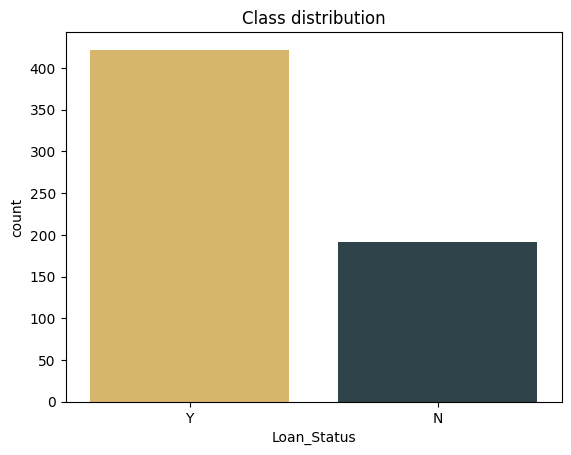

In [6]:
palette = ["#e7bd5b", "#2a454e"]
sns.countplot(x="Loan_Status",data=df,palette=palette)
plt.title("Class distribution")
plt.show()

**Note:** The target variable `Loan_Status` is **imbalanced**, with 422 approved loans (`Y`) and 192 not approved (`N`). This imbalance should be considered when training models, as it can bias predictions toward the majority class. Techniques like **oversampling, undersampling, or class weighting** can help address this issue.


#### Feature examination

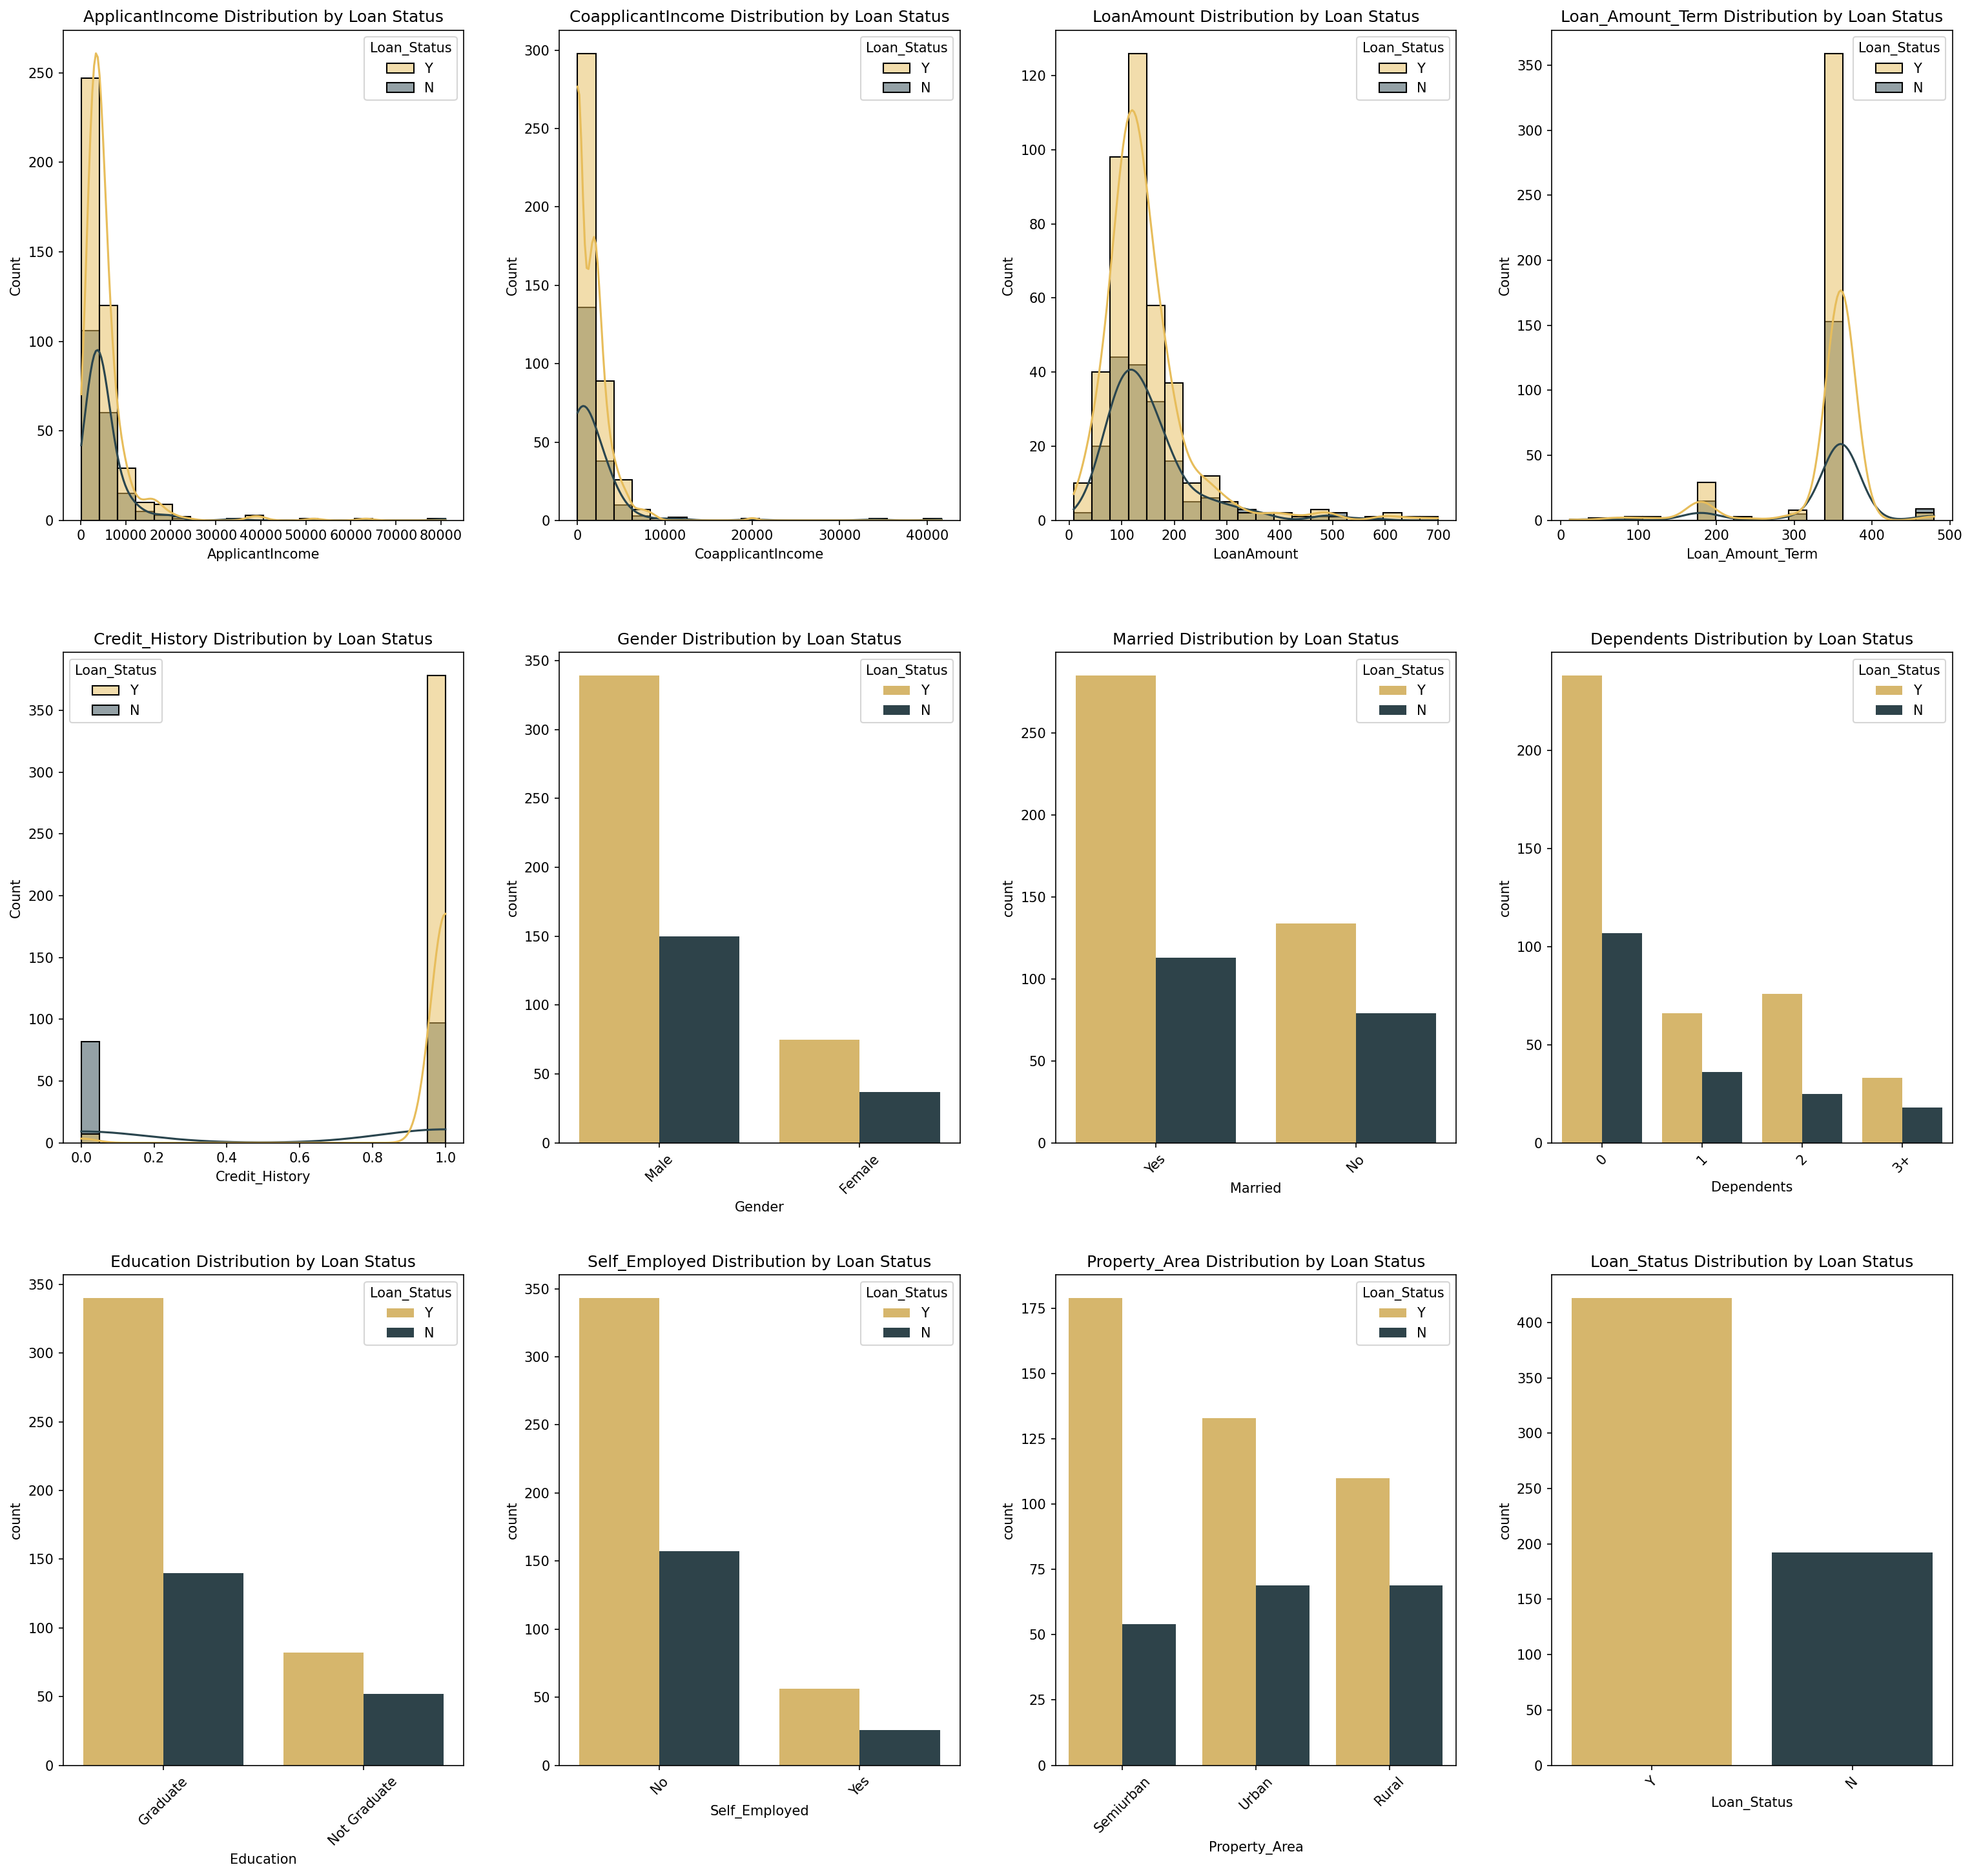

In [7]:
numeric_cols = df.select_dtypes(include='number').columns
categorial_cols = df.select_dtypes(include=["object","category"]).columns

all_cols = list(numeric_cols) + list(categorial_cols)
n_cols = 4

n_rows = (len(all_cols) + n_cols - 1 ) // n_cols

plt.figure(figsize=(7*n_rows, 5*n_cols),dpi=150)

for i, col in enumerate(all_cols):
    plt.subplot(n_rows,n_cols, i + 1)
    
    if col in numeric_cols:
        # Numeric distribution separated by Loan_Status
        sns.histplot(data=df, x=col, hue="Loan_Status", kde=True, bins=20, palette=palette)
    else:
        # Categorical counts separated by Loan_Status
        sns.countplot(x=col, data=df, hue="Loan_Status", order=df[col].value_counts().index, palette=palette)
        plt.xticks(rotation=45)
        
    plt.title(f"{col} Distribution by Loan Status",fontsize=12)
    
plt.tight_layout(pad=3.0)
plt.show()

Feature Distribution Analysis by Loan Status

- **Income and Loan Amount:**  
  Most applicants have lower `ApplicantIncome`, `CoapplicantIncome`, and `LoanAmount`. Approved loans (`Y`) slightly dominate across income levels, indicating higher income increases approval chances.  

- **Loan Amount Term:**  
  Most loans are for 360 months, with approvals (`Y`) slightly more frequent in this group.  

- **Credit History:**  
  Applicants with a positive credit history (`1`) are far more likely to get approved (`Y`), highlighting its strong influence.  

- **Demographic Features:**  
  - **Gender:** Male applicants are more common; approvals reflect this distribution.  
  - **Marital Status & Dependents:** Married applicants and those with fewer dependents have higher approval rates.  
  - **Education:** Graduates have a higher chance of loan approval.  
  - **Self Employed:** Non-self-employed applicants are approved more often.  

- **Property Area:**  
  Semiurban and urban applicants show higher approval rates than rural applicants.  

- **Target Variable:**  
  The dataset is imbalanced, with more approved loans (`Y`) than rejections (`N`).  

**Conclusion:**  
Income, credit history, education, and property area appear to be strong predictors of loan approval, while the target imbalance should be considered when training models.


### Pre-process dataset

In [8]:
from sklearn.impute import SimpleImputer
def preporcess_data(df):
    data = df.copy()
    label_encoders = {}
    categorical_column = df.select_dtypes(include=["object"]).columns.to_list()
    for col in categorical_column:
        le = LabelEncoder()
        data[col] = data[col].fillna("Unknown") if data[col].dtype == "object" else data[col]
        
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le
        
    numerical_column = df.select_dtypes(exclude=["object"]).columns.to_list()
    
    numeric_imputer = SimpleImputer(strategy="median")
    data[numerical_column] = numeric_imputer.fit_transform(data[numerical_column])
    scaler = StandardScaler()
    data[numerical_column] = scaler.fit_transform(data[numerical_column])
    return data, label_encoders,scaler,numerical_column,categorial_cols

data , label_encoders ,scaler,numerical_column,categorial_cols= preporcess_data(df)        
data.shape

(614, 12)

Pre-processeing data include : 

- **Encoding categorical features:**  
  For each categorical column:
  - Missing values are filled with `"Unknown"` to handle NaNs.
  - `LabelEncoder` is applied to convert string categories into numeric codes.
  - Each encoder is stored in `label_encoders` for potential inverse transformation later.

- **Imputing missing numeric values:**  
  `SimpleImputer(strategy="median")` replaces missing numeric values with the median of each column.

- **Scaling numeric features:**  
  `StandardScaler` standardizes numeric columns to have mean 0 and standard deviation 1, which helps many machine learning models converge faster.



In [9]:
def prepare_fearure_targer(data):    
    X = data.drop(columns="Loan_Status",axis=1)
    y = data["Loan_Status"]
    
    return X,y

X,y = prepare_fearure_targer(data)
print(X.shape,y.shape)

(614, 11) (614,)


#### Oversamling (using SMOTE)

**Definition:**  
SMOTE is a technique used to generate synthetic samples for the minority class in an imbalanced dataset. Instead of simply duplicating existing minority samples, it creates new, plausible examples by interpolating between existing minority instances.

**Purpose in Loan Prediction:**  
In a loan prediction project, the dataset may have fewer instances of one class (e.g., `Loan_Status = N`). Using SMOTE helps balance the classes, ensuring that the predictive model does not become biased toward the majority class and improves its ability to correctly predict minority outcomes.

In [10]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X ,y = smote.fit_resample(X,y)

In [11]:
print(y.value_counts())
print(X.shape)
print(y.shape)

Loan_Status
1    422
0    422
Name: count, dtype: int64
(844, 11)
(844,)


### split dataset

 The `train_test_split` function from `scikit-learn` is used to divide a dataset into training and validation subsets. This allows us to train a model on one portion of the data and evaluate its performance on unseen data.

In [12]:
X_train,X_val , y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=42)


print(X_train.shape)
print(X_val.shape)

print(y_train.shape)
print(y_val.shape)

(675, 11)
(169, 11)
(675,)
(169,)


The dataset contains a `test.csv` file that will be used to make predicitions.

In [13]:
test_data_file_path="dataset/train.csv"
df_test = load_data(test_data_file_path)
df_test.drop(columns="Loan_ID",inplace=True)
data_test , label_encoders_test ,scaler_test ,numerical_column_test,categorial_cols_test= preporcess_data(df_test)   
X_test,y_test = prepare_fearure_targer(data_test)

print(X_test.info())
X_test.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    int64  
 1   Married            614 non-null    int64  
 2   Dependents         614 non-null    int64  
 3   Education          614 non-null    int64  
 4   Self_Employed      614 non-null    int64  
 5   ApplicantIncome    614 non-null    float64
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         614 non-null    float64
 8   Loan_Amount_Term   614 non-null    float64
 9   Credit_History     614 non-null    float64
 10  Property_Area      614 non-null    int64  
dtypes: float64(5), int64(6)
memory usage: 52.9 KB
None


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,1,0,0,0,0,0.072991,-0.554487,-0.211241,0.273231,0.411733,2
1,1,2,1,0,0,-0.134412,-0.038732,-0.211241,0.273231,0.411733,0
2,1,2,0,0,2,-0.393747,-0.554487,-0.948996,0.273231,0.411733,2
3,1,2,0,1,0,-0.462062,0.251980,-0.306435,0.273231,0.411733,2
4,1,0,0,0,0,0.097728,-0.554487,-0.056551,0.273231,0.411733,2


In [14]:
X_train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
468,0,2,2,1,1,-0.850820,0.443165,-0.568220,0.273231,0.411733,1
786,0,0,4,0,0,-0.211592,-0.554487,-0.384251,1.136130,-2.428760,1
538,1,2,0,1,0,-0.407345,-0.371168,-0.948996,0.273231,0.411733,0
266,1,2,2,0,0,-0.113934,-0.080115,0.050543,0.273231,0.411733,1
352,1,2,3,0,0,-0.448465,0.157926,-0.603917,0.273231,0.411733,0


### Hyper-parameters optilization using GridSearch

`GridSearchCV` is a technique in `scikit-learn` used to systematically search through a predefined set of hyperparameters for a model to find the combination that gives the best performance based on a chosen evaluation metric.

#### Random Forest Classifier

A Random Forest Classifier is an ensemble learning method that builds multiple decision trees during training and combines their predictions to improve accuracy and reduce overfitting. Each tree is trained on a random subset of the data and a random subset of features, which introduces diversity and robustness to the model.

**Purpose in Loan Prediction:**  
It is used to predict loan approval (`Loan_Status`) by capturing complex relationships in the data, handling both numerical and categorical features, and being resilient to overfitting even with noisy or imbalanced datasets.

In [15]:
rf_params = {
    "n_estimators":[100, 200, 300],          # Number of trees in the forest
    "max_depth": [3, 5, 7, 15],             # Maximum depth of each tree
    "min_samples_split":[2, 5, 10],         # Minimum samples required to split a node
    "min_samples_leaf":[1, 2, 4],           # Minimum samples required at a leaf node
    "max_features":["sqrt","log2",None],    # Number of features to consider at each split
    "bootstrap":[True, False]               # Whether bootstrap samples are used
} 

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),  # The model to tune
    rf_params,                                # Grid of hyperparameters
    cv=5,                                     # 5-fold cross-validation
    scoring="f1_weighted",                    # Metric to optimize (handles class imbalance)
    n_jobs=-1,                                # Use all CPU cores
    verbose=1                                 # Print progress
)

rf_grid.fit(X_train, y_train)                

print(f"Random Forest Classifier, best params: {rf_grid.best_params_} \nScore: {rf_grid.best_score_:.2f}")

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Random Forest Classifier, best params: {'bootstrap': False, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200} 
Score: 0.80


* The best parameters achieved a weighted F1 score of 0.80, indicating a good ability to correctly predict loan statuses while handling class imbalance.

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       192
           1       0.97      0.97      0.97       422

    accuracy                           0.96       614
   macro avg       0.95      0.95      0.95       614
weighted avg       0.96      0.96      0.96       614



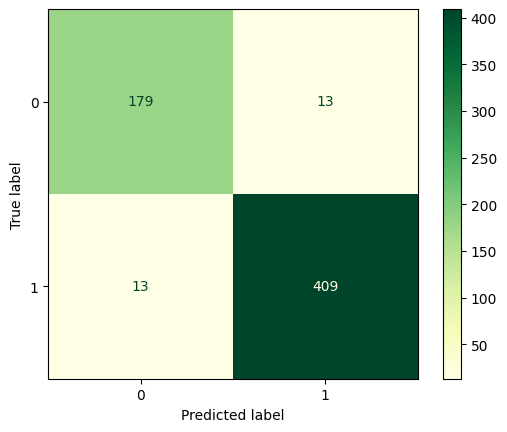

In [16]:
best_rf = rf_grid.best_estimator_

y_pred_rf = best_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))


cm = confusion_matrix(y_test,y_pred_rf)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="YlGn")

#### Logistic Regression

Logistic Regression is a linear model used for binary classification. It predicts the probability of a sample belonging to a class using the logistic function.

In [17]:
# logistic regression  parameters
lg_params = {
    'C': [0.01, 0.1, 1, 10, 100],       # Inverse of regularization strength (smaller values = stronger regularization)
    'penalty': ['l1','l2'],             # Type of regularization (L1 = Lasso, L2 = Ridge)
    'solver': ['liblinear','saga']      # Algorithm to optimize the logistic regression
} 

lg_grid = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),  # Logistic Regression model
    lg_params,                                           # Grid of hyperparameters to search
    cv=5,                                                # 5-fold cross-validation
    scoring="f1_weighted",                               # Metric to optimize
    n_jobs=-1,                                           # Use all CPU cores
    verbose=1                                             # Suppress detailed output
)

lg_grid.fit(X_train,y_train)

print(f"Logistic regression Classifier , best params : {lg_grid.best_params_} \n Score {lg_grid.best_score_:.2f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Logistic regression Classifier , best params : {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'} 
 Score 0.72


* The best parameters found were `C=0.1`, `penalty='l2'`, and `solver='saga'`, achieving an F1 score of 0.71.  
* This indicates that a stronger regularization (low C) with L2 penalty helps the model generalize better for predicting loan approvals while avoiding overfitting.

              precision    recall  f1-score   support

           0       0.79      0.49      0.60       192
           1       0.80      0.94      0.87       422

    accuracy                           0.80       614
   macro avg       0.80      0.72      0.74       614
weighted avg       0.80      0.80      0.78       614



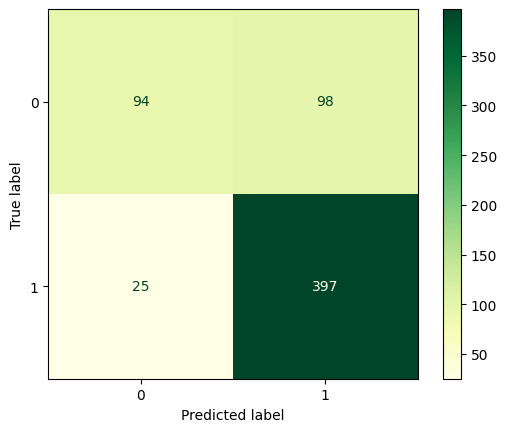

In [18]:
best_lg = lg_grid.best_estimator_

y_pred_lg = best_lg.predict(X_test)
print(classification_report(y_test, y_pred_lg))


cm_lg = confusion_matrix(y_test,y_pred_lg)

disp_lg = ConfusionMatrixDisplay(confusion_matrix=cm_lg)
disp_lg.plot(cmap="YlGn")

#### KNeighbor Classifier

K-Nearest Neighbors (KNN) is a non-parametric, instance-based learning algorithm that predicts the class of a sample based on the majority class among its `k` nearest neighbors in the feature space.

In [19]:
## knn params
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11],       # Number of neighbors to consider
    'weights': ['uniform','distance'],     # Weighting of neighbors (uniform = equal, distance = closer neighbors have more influence)
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metric used to find neighbors
}

knn_grid = GridSearchCV(
    KNeighborsClassifier(),  # KNN model
    knn_params,             
    cv=5,                    
    n_jobs=-1,               
    verbose=1               
)
knn_grid.fit(X_train,y_train)

print(f"KNeighborsClassifier, best params : {knn_grid.best_params_} \nScore : {knn_grid.best_score_:.2f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
KNeighborsClassifier, best params : {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'} 
Score : 0.77


The K-Nearest Neighbors model found the best hyperparameters to be `metric='manhattan'`, `n_neighbors=3`, and `weights='distance'`, achieving a weighted F1 score of 0.77.  
This indicates that considering 3 neighbors with distance-based weighting and using the Manhattan distance metric provides the best balance between local sensitivity and overall generalization for predicting loan approvals.

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       192
           1       0.97      0.96      0.97       422

    accuracy                           0.96       614
   macro avg       0.95      0.95      0.95       614
weighted avg       0.96      0.96      0.96       614



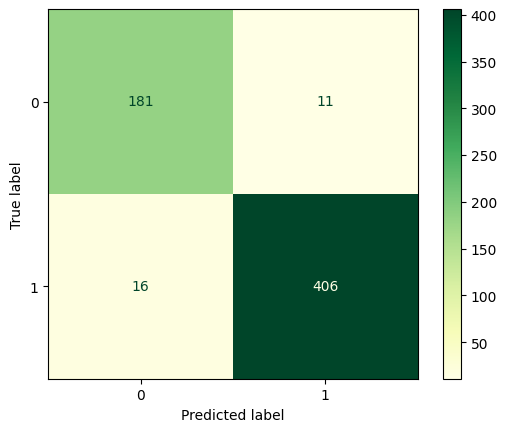

In [20]:
best_knn = knn_grid.best_estimator_

y_pred_knn = best_knn.predict(X_test)
print(classification_report(y_test, y_pred_knn))


cm_knn = confusion_matrix(y_test,y_pred_knn)

disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn)
disp_knn.plot(cmap="YlGn")

#### SVC Classifier

Support Vector Classifier (SVC) is a supervised learning algorithm that finds the optimal hyperplane separating classes in the feature space. It can handle linear and non-linear boundaries using different kernel functions.

In [21]:
from sklearn.svm import SVC

svc_params = {
    "C": [1, 10],                     # Regularization parameter (larger values = less regularization)
    "kernel": ["rbf","poly","sigmoid"],  # Type of kernel to transform data for non-linear decision boundaries
    "gamma": ["scale"]                 # Kernel coefficient for ‘rbf’, ‘poly’, and ‘sigmoid’ kernels
}

svc_grid = GridSearchCV(
    SVC(probability=True, random_state=42),  # SVC model
    svc_params,                               # Grid of hyperparameters
    cv=5,                                     # 5-fold cross-validation
    scoring="f1_weighted",                    
    n_jobs=-1,                               
    verbose=1                                
)

svc_grid.fit(X_train,y_train)

print(f"SVC - Best params: {svc_grid.best_params_} \n SVC - Best score: {svc_grid.best_score_:.4f}")


Fitting 5 folds for each of 6 candidates, totalling 30 fits
SVC - Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'} 
 SVC - Best score: 0.7357


* The Support Vector Classifier found the best hyperparameters to be `C=10`, `gamma='scale'`, and `kernel='rbf'`, achieving a weighted F1 score of 0.73.  
* This indicates that using a rbf kernel with moderate regularization allows the model to capture non-linear patterns in the data, improving its ability to predict loan approvals while balancing bias and variance.


              precision    recall  f1-score   support

           0       0.92      0.94      0.93       192
           1       0.97      0.96      0.97       422

    accuracy                           0.96       614
   macro avg       0.95      0.95      0.95       614
weighted avg       0.96      0.96      0.96       614



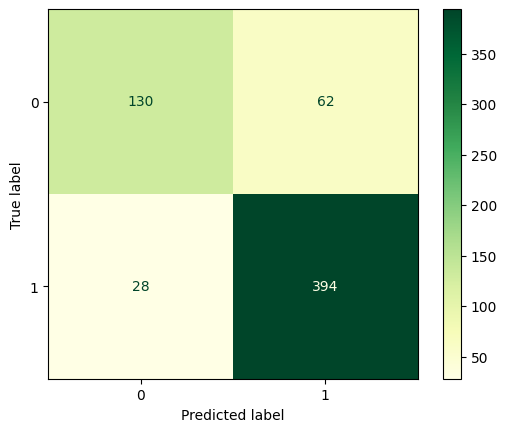

In [22]:
best_svc = svc_grid.best_estimator_

y_pred_svc = best_svc.predict(X_test)
print(classification_report(y_test, y_pred_knn))


cm_svc = confusion_matrix(y_test,y_pred_svc)

disp_svc = ConfusionMatrixDisplay(confusion_matrix=cm_svc)
disp_svc.plot(cmap="YlGn")

### Comparison of Individual Models for Loan Prediction

**Observations:**  
- **Random Forest** achieves the highest accuracy (0.96) and balanced F1-scores for both classes, showing robustness on imbalanced data.  
- **Logistic Regression** has high precision for class 0 but low recall (0.49), indicating it misses many positive loan approvals. Overall, its weighted F1 is lower (0.60).  
- **KNN** and **SVC** perform similarly with strong F1-scores (~0.92), good balance between precision and recall, and slightly lower accuracy than Random Forest.  

**Next Step:**  
To further improve performance, ensemble methods like **Voting (hard/soft)** and **Stacking** will be applied to combine the strengths of these models and determine the best algorithm for this loan prediction problem.

#### Apply ensemble learning

**Definition:**  
Ensemble learning is a machine learning approach where multiple models (often called "base learners") are combined to make predictions. By aggregating the strengths of different models, ensembles often achieve higher accuracy and robustness compared to individual models. Common strategies include bagging, boosting, and stacking.

 **Ensemble Strategies**  
   - **Voting Classifier (Hard)**: Predicts the class most frequently chosen by base learners.  
   - **Voting Classifier (Soft)**: Predicts the class based on average predicted probabilities of base learners.  
   - **Stacking**: Uses predictions of base learners as input features for a meta-model, learning to combine them optimally.

**Comparison Approach:**  
- Train each model and ensemble on the same training data.  
- Evaluate on the validation set using metrics like **F1 score**, **accuracy**, and **ROC-AUC**.  
- Compare the scores to identify which model or ensemble consistently performs best for predicting loan approvals.

This systematic comparison allows selecting the model that balances accuracy, generalization, and interpretability for the loan prediction task.


Voting Classifier (hard)

In [23]:
voting_classifier_hard = VotingClassifier(
    estimators=[
        ('xg',rf_grid.best_estimator_),
        ('lg',lg_grid.best_estimator_),
        ('knn',knn_grid.best_estimator_),
        ('svc',svc_grid.best_estimator_),
    ],
    voting='hard'
)

Voting Classifier (soft)

In [24]:
voting_classifier_soft = VotingClassifier(
    estimators=[
        ('xg',rf_grid.best_estimator_),
        ('lg',lg_grid.best_estimator_),
        ('knn',knn_grid.best_estimator_),
        ('svc',svc_grid.best_estimator_),
    ],
    voting='soft'
)

Stacking Classifier

In [25]:
stacking_classifier = StackingClassifier(
    estimators=[
        ('xg',rf_grid.best_estimator_),
        ('lg',lg_grid.best_estimator_),
        ('knn',knn_grid.best_estimator_),
        ('svc',svc_grid.best_estimator_),
    ],
    final_estimator=GradientBoostingClassifier(),
    cv=5,
    passthrough=False
)

In [35]:
models = {
    'Random Forest Classifier':rf_grid.best_estimator_,
    'Logistic Regression':lg_grid.best_estimator_,
    'KNN':knn_grid.best_estimator_,
    'SVC': svc_grid.best_estimator_,
    'Voting Hard':voting_classifier_hard,
    'Voting Soft':voting_classifier_soft,
    'Stacking':stacking_classifier
}
results = {}
for name,model in models.items():
    print(f"Entraînement de {name}...")
    
    model.fit(X_train,y_train)
    y_pred = model.predict(X_val)
    
    accuracy = accuracy_score(y_val,y_pred)
    f1 = f1_score(y_val, y_pred, average='weighted')
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    
        
    results[name] = {
        'accuracy': accuracy,
        'f1_score': f1,
        "Precision":precision,
        "recall":recall
    }
        
    print(f"{name} - Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}")

Entraînement de Random Forest Classifier...
Random Forest Classifier - Accuracy: 0.7692, F1-Score: 0.7699
Entraînement de Logistic Regression...
Logistic Regression - Accuracy: 0.6627, F1-Score: 0.6486
Entraînement de KNN...
KNN - Accuracy: 0.7574, F1-Score: 0.7582
Entraînement de SVC...
SVC - Accuracy: 0.6746, F1-Score: 0.6641
Entraînement de Voting Hard...
Voting Hard - Accuracy: 0.7811, F1-Score: 0.7815
Entraînement de Voting Soft...
Voting Soft - Accuracy: 0.7633, F1-Score: 0.7623
Entraînement de Stacking...
Stacking - Accuracy: 0.7396, F1-Score: 0.7403


In [27]:
df_results = pd.DataFrame(results).T.sort_values(by="f1_score",ascending=False)
df_results

,accuracy,f1_score,Precision,recall
Voting Hard,0.781065,0.781525,0.711111,0.853333
Random Forest Classifier,0.769231,0.769862,0.704545,0.826667
Voting Soft,0.763314,0.762318,0.676768,0.893333
KNN,0.757396,0.758164,0.702381,0.786667
Stacking,0.739645,0.740284,0.674157,0.800000
SVC,0.674556,0.664101,0.586207,0.906667
Logistic Regression,0.662722,0.648570,0.575000,0.920000


Based on the validation metrics:

**Observations:**  
- **Voting Hard** has the highest overall F1-score (0.781) and a good balance between precision and recall, making it the most reliable model for this dataset.  
- **Random Forest** and **Voting Soft** also perform well, with similar accuracy and F1-scores, but slightly lower recall or precision compared to Voting Soft.  
- **Logistic Regression** and **SVC** achieve high recall but much lower precision, meaning they tend to over-predict positive loans.  
- **KNN** and **Stacking** perform moderately but are outperformed by the top ensembles.

The **Voting Hard ensemble** is currently the best-performing approach for predicting loan approvals, as it combines the strengths of multiple models, balancing precision and recall effectively. Next, further fine-tuning or stacking could be explored to see if performance can be improved even more.


#### Saving model 

In [30]:
from joblib import dump, load

# Save the trained model
dump(rf_grid.best_estimator_, "models/rf.joblib")
dump(lg_grid.best_estimator_, "models/lg.joblib")
dump(knn_grid.best_estimator_, "models/knn.joblib")
dump(voting_classifier_hard, "models/voting_classifier_hard.joblib")
dump(voting_classifier_soft, "models/voting_classifier_soft.joblib")
dump(stacking_classifier, "models/stacking_classifier.joblib")
dump(svc_grid.best_estimator_,"models/svc.joblib")


dump(label_encoders, 'processors/label_encoders.pkl')
dump(scaler, 'processors/scaler.pkl')
dump(X.columns.to_list(), 'processors/feature_names.pkl')
dump({'numerical': numerical_column, 'categorical': categorial_cols}, 'processors/column_types.pkl')

['processors/column_types.pkl']